In [1]:
import os, sys
sys.path.append("src/")
os.environ["CUDA_VISIBLE_DEVICES"] = "1,"
from pathlib import Path
from types import SimpleNamespace
import math, json
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch

from musubi_tuner.dataset.image_video_dataset import resize_image_to_bucket
from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import encode_prompt_conds, vae_encode, vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.frame_pack.utils import crop_or_pad_yield_mask
from musubi_tuner.wan_generate_video import merge_lora_weights

sys.path.append("/data/whisperer/utils")
from img_utils import convert_from_qwen2vl_format
from vistory_utils import StoryDataset

device = torch.device('cuda')
lt.monkey_patch()

2025-07-25 10:36:18.254054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753407378.272447   32515 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753407378.278102   32515 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-25 10:36:18.297037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment 

Trying to import sageattention
Successfully imported sageattention


In [2]:
dit_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors"
vae_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "/shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "/shared/video/ComfyUI/models/text_encoders/clip_l.safetensors"
image_encoder_path = "/shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"
lora_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Lora/framepack/fpack_1fmc_bg_lora/bg_lora_1000.safetensors"
# lora_path = "/data/whisperer/related/framepackbase/musubi-tuner/outputs/training/s2vnexus_posecontrol_lora/lora_test1-000004.safetensors"

model = load_packed_model(device, dit_path, 'sageattn', device)
model.to(device)
model.eval().requires_grad_(False)
merge_lora_weights(lora_framepack, model, 
    SimpleNamespace(
        lora_weight = [lora_path], lora_multiplier = [1.0], 
        include_patterns=None, exclude_patterns=None, lycoris=None,
        save_merged_model=False
    ), 
device, None)
vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=text_encoder1_path), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=text_encoder2_path))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=image_encoder_path))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, info=<All keys matched successfully>
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Lora/framepack/fpack_1fmc_bg_lora/bg_lora_1000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE model (8

In [3]:
def get_text_preproc(prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, entity_prompts=[], device=torch.device('cuda'), dtype=torch.bfloat16):
    with torch.autocast(device_type=device.type, dtype=text_encoder1.dtype), torch.no_grad():
        llama_vecs = []
        llama_vecs_inds = []
        llama_strtokens = {}
        start_ind = 0
        for i, p in enumerate([prompt] + entity_prompts):
            llama_vec_i, clip_l_pooler_i, llama_strtokens_i = encode_prompt_conds(
                p, text_encoder1, text_encoder2, tokenizer1, tokenizer2, custom_system_prompt=None, return_tokendict=True
            )
            llama_vecs.append(llama_vec_i)
            llama_vecs_inds.append(llama_vec_i.shape[1])
            llama_strtokens.update({start_ind+i:x for i,x in llama_strtokens_i.items()})
            if i == 0:
                clip_l_pooler = clip_l_pooler_i
            start_ind += llama_vec_i.shape[1]
            
        llama_vec = torch.cat(llama_vecs, dim=1).to(device, dtype=dtype)
        clip_l_pooler = clip_l_pooler.to(device, dtype=dtype)
        llama_vec, llama_attention_mask = crop_or_pad_yield_mask(llama_vec, length=512)
        llama_vecs_inds = [(sum(llama_vecs_inds[:i]), sum(llama_vecs_inds[:i+1])) for i,x in enumerate(llama_vecs_inds)]

    llama_vec_n = torch.zeros_like(llama_vec).to(device, dtype=dtype)
    clip_l_pooler_n  = torch.zeros_like(clip_l_pooler).to(device, dtype=dtype)
    llama_vec_n, llama_attention_mask_n = crop_or_pad_yield_mask(llama_vec_n, length=512)
    return {
        "prompt_embeds" : llama_vec,
        "prompt_embeds_mask" : llama_attention_mask,
        "prompt_poolers" : clip_l_pooler,
        "prompt_entity_inds" : llama_vecs_inds,
        "prompt_strtokens" : llama_strtokens,
        "negative_prompt_embeds" : llama_vec_n,
        "negative_prompt_embeds_mask" : llama_attention_mask_n,
        "negative_prompt_poolers" : clip_l_pooler_n,
    }

def getres(orig_width, orig_height, target_area=480*480, div_factor=16):
    if target_area is not None:
        aspect_ratio = orig_width / orig_height
        new_height = math.sqrt(target_area / aspect_ratio)
        new_width = target_area / new_height
    else:
        new_width, new_height = orig_width, orig_height
    new_width = int(round(new_width / div_factor) * div_factor)
    new_height = int(round(new_height / div_factor) * div_factor)

    return new_width, new_height

def preproc_image(image_path, width=None, height=None):
    image_pil = Image.open(image_path).convert("RGB")
    image_np = np.array(image_pil)
    if width is not None and height is not None:
        image_np = resize_image_to_bucket(image_np, (width, height))
    image_tensor = (torch.from_numpy(image_np).float() / 127.5 - 1.0).permute(2,0,1)[None, :, None]
    return image_tensor, image_np

def preproc_mask(mask_path, width, height, invert=False):
    if mask_path == '':
        image_pil = Image.new("L", (width // 8, height // 8), 255)
    else:
        image_pil = Image.open(mask_path).convert("L")
    if invert:
        image_pil = ImageOps.invert(image_pil)
        
    image_np = np.array(image_pil)
    if width is not None and height is not None:
        image_np = resize_image_to_bucket(image_np,  (width // 8, height // 8))
    image_tensor = (torch.from_numpy(image_np).float() / 255.0)[None, None, None, :, :]
    return image_tensor, image_np

def prepare_image_inputs(image_paths, feature_extractor, image_encoder, width=None, height=None, 
                         target_index=1, device=torch.device('cuda'), dtype=torch.bfloat16):
    image_embeddings, img_nps = [], []
    if type(image_paths) == str:
        image_paths = [image_paths]

    with torch.no_grad():
        for image_path in image_paths:
            _, img_np = preproc_image(image_path, width, height)
            image_encoder_output = hf_clip_vision_encode(img_np, feature_extractor, image_encoder)
            image_encoder_last_hidden_state = image_encoder_output.last_hidden_state.to(device, dtype=dtype)
            image_embeddings.append(image_encoder_last_hidden_state)
            img_nps.append(img_np)

    latent_indices = torch.tensor([target_index], dtype=torch.int64)  # 1x1 latent index for target image
    return {
        "image_embeddings" : image_embeddings,
        "latent_indices" : latent_indices,
    } , img_nps

def prepare_control_inputs(control_image_paths, control_image_mask_paths, width=None, height=None,
                           control_indices=[0,10]):
    control_latents, control_nps = [], []
    for i, (control_image_path, control_mask_path) in enumerate(zip(control_image_paths, control_image_mask_paths)):
        c_img_tensor, c_img_np = preproc_image(control_image_path, width, height)
        c_img_latent = vae_encode(c_img_tensor, vae).cpu()
        c_mask_image, c_mask_np = preproc_mask(control_mask_path, width, height)
        c_img_latent = c_img_latent * c_mask_image
        control_latents.append(c_img_latent)
        control_nps.append(np.concatenate([c_img_np, resize_image_to_bucket(c_mask_np, (width, height))[..., None]], -1))
    clean_latents = torch.cat(control_latents, dim=2)  # (1, 16, num_control_images, H//8, W//8)
    clean_latent_indices = torch.tensor([control_indices], dtype=torch.int64)

    return {
        "clean_latents" : clean_latents, 
        "clean_latent_indices" : clean_latent_indices,
        "clean_latents_2x" : None, 
        "clean_latent_2x_indices" : None,
        "clean_latents_4x" : None, 
        "clean_latent_4x_indices" : None,
    } , control_nps

In [19]:
tmp = Image.open("outputs/vistory_tmp/vistory_04_04_mask.png").convert("L")
draw = ImageDraw.Draw(tmp)
draw.rectangle((0,0,800,704), fill=(255,))

tmp.save("outputs/vistory_tmp/vistory_04_04_mask_bg.png")
ImageOps.invert(tmp).save("outputs/vistory_tmp/vistory_04_04_mask_fg.png")

In [35]:
# prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
# height, width = 480, 480

# control_image_paths = ["docs/bg_sample.png", "docs/fg_sample.jpg"]
# control_image_mask_paths = ["", ""]

# image_paths = ["docs/bg_sample.png"]
# entity_prompts = ["An anime-style girl wearing a school uniform and ribbon tie"]
# entity_masks = ["docs/bg_sample_mask.png", 'docs/bg_sample_mask_inverted.png']

prompt = 'Chinese Ancient Wuxia. The red-clothed maiden and the burly man engage in a fierce battle on the stage. The maiden moves gracefully with agile techniques, while the man is strong and powerful. The surrounding crowd cheers excitedly.'
height, width = 336, 672

control_image_paths = ["outputs/vistory_tmp/vistory_04_04_bg.png", "/data/whisperer/datasets/storyviz/ViStoryBench/ViStoryBench/04/image/Red-Clothed Maiden/00.jpg"]
control_image_mask_paths = ["", ""]

image_paths = ["outputs/vistory_tmp/vistory_04_04_bg.png"]
entity_prompts = ["red-clothed maiden"]
entity_mask_paths = ["outputs/vistory_tmp/vistory_04_04_mask_bg.png", "outputs/vistory_tmp/vistory_04_04_mask_fg.png"]

target_index = [1]
control_indices = [0,10]

In [32]:

## Text Preprocessing
text_kwargs = get_text_preproc(prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, entity_prompts=entity_prompts, device=device)

## Image Preprocessing
image_kwargs, img_np = prepare_image_inputs(
    image_paths, feature_extractor, image_encoder, width=width, height=height, 
    target_index=target_index, device=device, dtype=torch.bfloat16)

## Control Preprocessing
control_kwargs, control_nps = prepare_control_inputs(
    control_image_paths, control_image_mask_paths, width=width, height=height, 
    control_indices=control_indices)

entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entity_mask_paths], 1)

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 2646, 3072] bf16 n=8128512 (16Mb) x∈[-16.000, 18.375] μ=-0.020 σ=1.594 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 780, 3072] bf16 n=2396160 (4.6Mb) x∈[-2.976e+03, 2.560e+03] μ=0.348 σ=151.000 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.625, 19.500] μ=-0.103 σ=0.930 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 3426, 3426] bf16 n=11737476 (22Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 2646, 256] n=677376 (2.6Mb) x∈[-1.000, 1.000] μ=0.371 σ=0.602 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'clean_latents': [(0, 882), (882, 1764)], 'noise': [(1764, 2646)], 'image_embeddings': [(2646, 3375)], 'text_embeddings': [(3375, 3420), (3420, 3426)]})


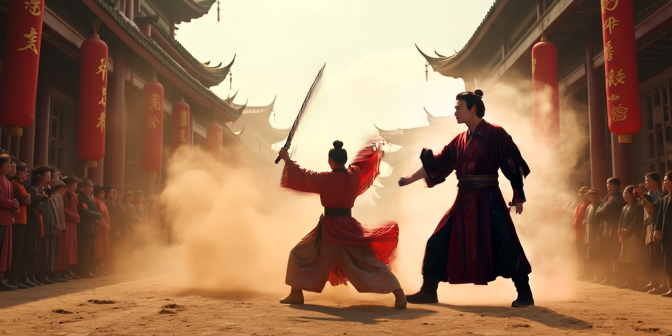

In [33]:
num_inference_steps=25
seed = np.random.randint(2**31)
# seed = 2105350387 1989424941
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=num_inference_steps,
    generator=generator, device=device, dtype=torch.bfloat16,
    cache_results=True, cache_layers = [], 
    clean_latent_bbox=None,
    use_attention_masking=["no_cross_control_latents", "mask_entities", "mask_control"],
    entity_masks=entity_masks,
    **text_kwargs, 
    **image_kwargs,
    **control_kwargs
)
history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)
result_img = np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)

# Image.fromarray(np.concatenate(control_nps + [result_img], axis=1))
Image.fromarray(result_img)

defaultdict(<class 'list'>, {'clean_latents': [(0, 882), (882, 1764)], 'noise': [(1764, 2646)], 'image_embeddings': [(2646, 3375)], 'text_embeddings': [(3375, 3420), (3420, 3426)]})


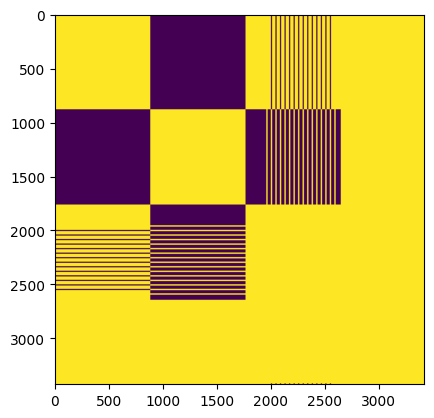

In [34]:
print(attn_cache['attn_dict'])
attn_mask = attn_cache['attn_mask'].clone()
attn_mask[attn_mask > -9999.] = 1
attn_mask[attn_mask < -9999.] = 0
attn_mask = attn_mask.bool().cpu().numpy()[0]
plt.imshow(attn_mask)